<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" title="Title text" width="20%" />

<hr style="height:2px;border:none"/>
<H1 align='center'> Challenge Kaggle </H1>
<H5 align='center'> Predicción Velocidad del viento: Solución </H5>

<H3> INF-395 Redes Neuronales y Deep Learning </H3>
<H3> Autores: Francisco Andrades | Lucas Díaz</H3>

Lenguaje: Python

Temas:

    - Redes Neuronales Recurrentes.
    - Modelos Generativos.
    - Autoencoders.
    - Modelos Especiales.
    
Link Competencia: https://www.kaggle.com/c/prediccin-velocidad-del-viento

Equipo: Bios

Video Explicativo: https://youtu.be/WYjm28I2uMw

<hr style="height:2px;border:none"/>

### Contexto

Queremos predecir la velocidad media del viento a 20 metros de altura en diferentes instantes de tiempo.

### Dataset

El dataset contiene la velocidad media del viento a 20 metros de altura para cada instante de tiempo determinado. El conjunto de entrenamiento contiene 123365 registros cada 10 minutos de la velocidad media del viento desde el 19 de Diciembre de 2012 a las 00:10 hasta el 24 de Abril de 2015 a las 23:50. El conjunto de test consiste en diferentes instantes de tiempo a partir del 26 de Abril de 2015

**La métrica de evaluación para esta competencia es RMSE** 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
path = '../input/prediccin-velocidad-del-viento/'
from statsmodels.tsa.stattools import acf, pacf
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

## Enfoque base

- Predecir 24 horas siguientes usando 24 horas anteriores.
- Predecir multi-step de forma recursiva.
- Utilizar variables exógenas en un contexto multivariado (Media mensual y Media hora).

Recordando algunas conclusiones importante obtenidad del notebook EDA:

    - Año 2015 pareciera tener un shift de 17 días con respecto al año 2014.
    - Año 2015 se regulariza.
    
Se tomaron las siguientes decisiones:

    - No se va a aplicar el shift debido a que la correlación, aunque máxima, era muy baja (0.2)
    - El año 2015 se va a regularizar cuando se modelen los datos en una escala mensual

In [30]:
# Se leen los datos y se transforman a formato datetime
from datetime import timedelta
df_train = pd.read_csv(path+'windspeed-training.csv')
df_train['Fecha'] =  pd.to_datetime(df_train['Fecha'])
df_train['year'] = df_train.Fecha.dt.year
df_train['hour'] = df_train.Fecha.dt.hour

df_train['day'] = df_train.Fecha.dt.day
df_train['month'] = df_train.Fecha.dt.month

df_test = pd.read_csv(path+'windspeed-testing.csv')
df_test.columns = ['Fecha']
df_test['Fecha'] =  pd.to_datetime(df_test['Fecha'],format="%d-%m-%Y %H:%M")
df_test['year'] = df_test.Fecha.dt.year
df_test['hour'] = df_test.Fecha.dt.hour

df_test['day'] = df_test.Fecha.dt.day
df_test['month'] = df_test.Fecha.dt.month
df_test.shape

(1999, 5)

## Promedio a escala meses (12 valores por año)

Debemos construir una media a escala mensual para cada año.

Para los años 2013 y 2014 ya se tiene.

Para el año 2015, hay que aproximarla.

Ya se decidió que el año 2015 se va a regularizar, sin embargo aún se debe decidir que tan rápido lo va a hacer. 

La solución propuesta consiste en que el año 2015 (a partir de mayo) busque siempre alcanzar la media de los años (2013,2014). Para controlar la velocidad de regularización, se establece una diferencia máxima entre un mes y el anterior. Este parámetro, llamado max_dif, es un hiperparámetro de nuestro enfoque. El valor que se escogió para la solución ganadora es 2. Este valor es lo suficientemente grande como para que el año se regularice de inmediato. 

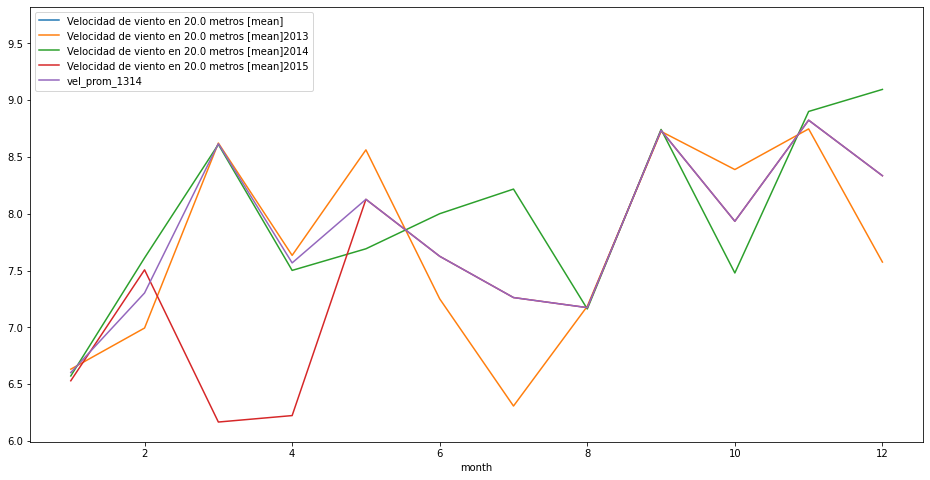

Demostración de una regularización más lenta, con max_dif = 0.4


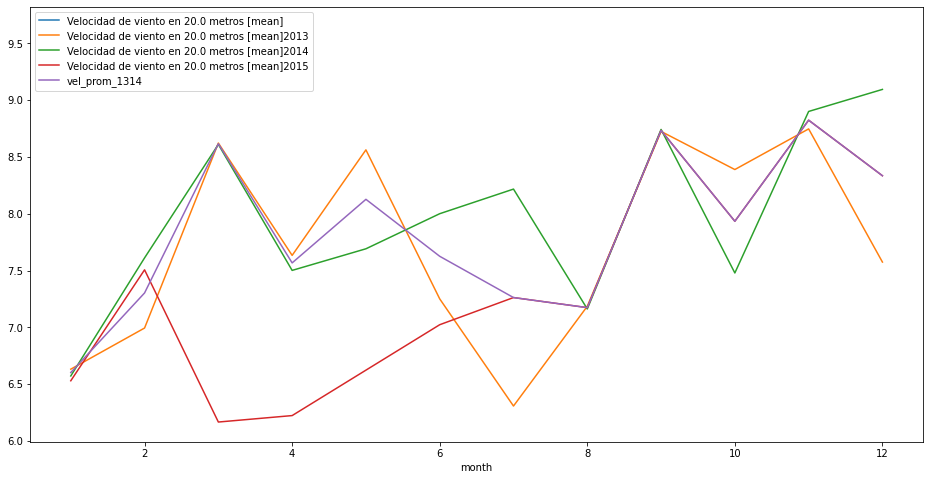

In [31]:
def escala_meses(df_train_new, max_dif = 0.6, plot=False, N = 2):
    """
    df_train_new: df_train separado por columnas: año, mes, día, hora
    max_dif     : tolerancia 
    N           : N=1 -> 2014 ; N=2 -> 2015
    """
    df_train = df_train_new.copy()
    pivotx = df_train.pivot_table(index=['year','month'], 
                                  values=df_train.columns[1], 
                                  aggfunc=np.mean
                                 )
    tabla_2012 = pivotx.loc[(2012,)]
    tabla_2013 = pivotx.loc[(2013,)]
    tabla_2014 = pivotx.loc[(2014,)]
    tabla_2015 = pivotx.loc[(2015,)]
    #display(tabla_2013)
    info_per_year = tabla_2012.join(tabla_2013,how='outer',rsuffix='2013')
    info_per_year = info_per_year.join(tabla_2014,how='outer',rsuffix='2014')
    info_per_year = info_per_year.join(tabla_2015,how='outer',rsuffix='2015') # columns: years; rows: months
    
    # se agrega media usando 2013-2014
    info_per_year['vel_prom_1314'] = info_per_year.iloc[:, [1, 2]].mean(axis=1)
    #info_per_year.iloc[4,N-1] = info_per_year.iloc[4,N-1] + (info_per_year.iloc[4,N-1] -info_per_year.iloc[3,N-1])


    #display(info_per_year)
    #N: datos del año dado
    for i in range(3, 11):# de abril a "octubre" 
        #display(info_per_year)
        sign = np.sign(info_per_year.iloc[i+1, N] - info_per_year.iloc[i, N-1])
        if np.abs(info_per_year.iloc[i, N-1] - info_per_year.iloc[i+1, N]) <= max_dif:
            info_per_year.iloc[i+1, N-1] = info_per_year.iloc[i+1, N]
            break # ya encontró el "vecindario" por donde pasa la media
        else:
            # no se permiten diferencias significativas
            info_per_year.iloc[i+1, N-1] = info_per_year.iloc[i, N-1] + sign*max_dif
    
    #copia datos del año 2014 al 2015 así tal cual
    for j in range(i, 11):
        info_per_year.iloc[j+1, N-1] = info_per_year.iloc[j+1,N]
       

    if plot:
        if N == 4:
            info_per_year.plot(figsize=(16, 8))
            plt.show()
            return info_per_year.iloc[:, N-1]
        #else:
        #    info_per_year.iloc[:, [0, 1, 2]].plot(figsize=(16, 8))
        #    return info_per_year.iloc[:, N+1]
        
    return info_per_year.iloc[:, N-1]#info_per_yea
meses_2015 = escala_meses(df_train, max_dif=2, plot=True,N=4)
print("Demostración de una regularización más lenta, con max_dif = 0.4")
demostracion = escala_meses(df_train, max_dif=0.4, plot=True,N=4)
meses_2014 = df_train.pivot_table(index=['year','month'], 
                                  values=df_train.columns[1], 
                                  aggfunc=np.mean
                                 ).loc[(2014,)].values.squeeze()#escala_meses(df_train, max_dif=0.5, plot=True,N=1)
#print(meses_2014)
meses_2013 = df_train.pivot_table(index=['year','month'], 
                                  values=df_train.columns[1], 
                                  aggfunc=np.mean
                                 ).loc[(2013,)].values.squeeze()

serie_2013 = pd.Series(meses_2013,index=range(1,13),name='meses_2013')
serie_2014 = pd.Series(meses_2014,index = range(1,13),name='meses_2014')
serie_2015 = pd.Series(meses_2015,index = range(1,13),name='meses2015')

## Promedio a escala horas (24 valores por año)

In [32]:
# Se obtiene el promedio de cada hora, ya se vió en el EDA que estos valores son extremadamemte relevantes.
horas_2013 = df_train.pivot_table(index = 'hour',values=df_train.columns[1])
horas_2015 = df_train.pivot_table(index = 'hour',values=df_train.columns[1])
horas_2014 = df_train.pivot_table(index = 'hour',values=df_train.columns[1])

### Construcción de los datos

In [33]:
#juntando atributos
def juntar(year,horas_2014,serie_2014):
    targets = df_train.loc[df_train.year == year,[df_train.columns[1],"month","day","hour"]]#cambiar
    aux = targets.pivot_table(index=["month","hour"],values=targets.columns[0])#cambiar
    targets = df_train.loc[df_train.year == year,[df_train.columns[1],"month","day","hour"]]
    targets = targets.pivot_table(index=["month","day","hour"])
    arr_2014 = targets.join(horas_2014,on='hour',rsuffix='_hours')
    arr_2014 = arr_2014.join(serie_2014,on=('month'))
    arr_2014 = arr_2014.join(aux,on=['month','hour'],rsuffix='mean')#cambiar
    arr_2014.columns = ["target","horas","meses","prom"]#cambiar
    return arr_2014

arr_2014 = juntar(2014,horas_2014,serie_2014)
arr_2013 = juntar(2013,horas_2013,serie_2013)
arr_2015 = juntar(2015,horas_2015,serie_2015)
print("Datos 2013")
display(arr_2013)
print("Datos 2014")
display(arr_2014)
print("Datos 2015 (que se tienen)")
display(arr_2015)

#test
targets = df_train.loc[df_train.year <= 2015,[df_train.columns[1],"month","day","hour"]]
targets = targets[targets.month > 4]#cambiar
targets = targets.append(df_train.loc[df_train.year == 2015,[df_train.columns[1],"month","day","hour"]])
aux = targets.pivot_table(index=["month","hour"],values=targets.columns[0])#cambiar
targets = df_train.loc[df_train.year == 2013,[df_train.columns[1],"month","day","hour"]]
targets = targets.pivot_table(index=["month","day","hour"])
test = targets.join(horas_2015,on='hour',rsuffix='_hours')
test = test.join(serie_2015,on=('month'))
test = test.join(aux,on=['month','hour'],rsuffix='mean')#cambiar
test.columns = ["target","horas","meses","prom"]#cambiar
test.drop('target',axis=1,inplace=True)
test = test.loc[range(4,10)]
test = test.iloc[24*24:]
print("Datos 2015 (que se piden)")
display(test)

Datos 2013


target      horas     meses       prom
month day hour                                           
1     1   0      2.866667   6.951760  6.631631   5.928495
          1      2.283333   6.422443  6.631631   5.195161
          2      2.066667   5.996266  6.631631   4.328495
          3      1.516667   5.489712  6.631631   3.710215
          4      2.083333   5.066394  6.631631   3.382796
...                   ...        ...       ...        ...
12    31  19    14.916667  10.184307  7.574888  12.527419
          20    13.983333   9.556484  7.574888  12.302151
          21    13.250000   8.806231  7.574888  10.948387
          22    12.183333   8.113279  7.574888   9.889785
          23    10.866667   7.508255  7.574888   8.497849

[8760 rows x 4 columns]

Datos 2014


target      horas     meses       prom
month day hour                                           
1     1   0      9.500000   6.951760  6.572156   6.222043
          1      9.333333   6.422443  6.572156   5.466667
          2      9.083333   5.996266  6.572156   5.216129
          3      6.033333   5.489712  6.572156   4.696237
          4      6.850000   5.066394  6.572156   4.092473
...                   ...        ...       ...        ...
12    31  19    11.533333  10.184307  9.095004  13.326882
          20    16.066667   9.556484  9.095004  12.189247
          21    13.700000   8.806231  9.095004  11.787097
          22    12.116667   8.113279  9.095004  10.057527
          23    11.550000   7.508255  9.095004   9.027957

[8753 rows x 4 columns]

Datos 2015 (que se tienen)


target      horas     meses      prom
month day hour                                          
1     1   0     11.766667   6.951760  6.529615  6.043011
          1     12.016667   6.422443  6.529615  4.854301
          2     12.083333   5.996266  6.529615  4.482258
          3     12.550000   5.489712  6.529615  4.045699
          4     12.700000   5.066394  6.529615  3.299462
...                   ...        ...       ...       ...
4     24  19     5.566667  10.184307  6.223061  9.206250
          20     6.533333   9.556484  6.223061  7.628472
          21     3.583333   8.806231  6.223061  6.777083
          22     4.150000   8.113279  6.223061  6.362500
          23     1.683333   7.508255  6.223061  5.681944

[2736 rows x 4 columns]

Datos 2015 (que se piden)


horas     meses      prom
month day hour                               
4     25  0      6.951760  6.223061  5.371528
          1      6.422443  6.223061  4.762500
          2      5.996266  6.223061  4.079861
          3      5.489712  6.223061  3.659028
          4      5.066394  6.223061  3.138194
...                   ...       ...       ...
9     30  19    10.184307  8.733843  9.452500
          20     9.556484  8.733843  8.499444
          21     8.806231  8.733843  7.520556
          22     8.113279  8.733843  7.474444
          23     7.508255  8.733843  7.117778

[3816 rows x 3 columns]

La columna 'prom' no se ocupa, es sólo un valor para una comparación final. Esto se explica en detalle al final del notebook.

In [34]:
#arr_2015 = arr_2014.loc[[5,6,7,8]]
#arr_2014 = arr_2014.loc[[1,2,3,4]]

In [35]:
#transformar datos para LSTM
def transform(arr_2013):
    arr_test = arr_2013.copy()
    arr_test['combined']= (arr_test.values.tolist())
    arr_test = arr_test.drop(arr_test.columns[:4],axis=1)#cambiar
    arr_test = arr_test.pivot_table(index=['month','day'],aggfunc = list)
    arr_test = pd.DataFrame(arr_test['combined'].values.tolist())
    #display(arr_test)
    for elem in range(24):
        arr_test[str(elem)+'_target'] = np.nan
        arr_test[str(elem)+'_target'] = arr_test[str(elem)+'_target'].astype(float)
    lista = arr_test.index[1:]
    for indice in lista:
        obtener = arr_test.loc[indice].values
        for elem in range(24):
            #print(obtener[elem])
            try:
                arr_test.loc[indice-1,str(elem)+'_target'] = obtener[elem][0]
            except:
                arr_test.loc[indice-1,str(elem)+'_target'] = np.nan
            #arr_test.loc[indice-1,str(elem)+'_target'] = obtener[elem][0]
        #arr_test.drop(indice,inplace=True)
    return arr_test.iloc[:-1]

entrenar_2013 = transform(arr_2013)
entrenar_2014 = transform(arr_2014)
testear = transform(arr_2015)

In [36]:
# Transformar test para LSTM
arr_test = test.copy()
arr_test['combined']= (arr_test.values.tolist())
arr_test = arr_test.drop(arr_test.columns[:3],axis=1)#cambiar
arr_test = arr_test.pivot_table(index=['month','day'],aggfunc = list)
arr_test = pd.DataFrame(arr_test['combined'].values.tolist())
#display(arr_test)

test_listo = arr_test

In [37]:
#Se concatenan los datos de entrenamiento
entrenar = pd.concat([entrenar_2013,entrenar_2014])
entrenar.index = range(entrenar.shape[0])
entrenar = entrenar.interpolate()
entrenar.dropna(axis=0,inplace=True)

In [38]:
#Se transforman los datos y se convierten en numpy arrays
# El input del modelos van a ser las 24 horas anteriores
# representadas de la forma (target,mean_mes,mean_hora) X 24
# El output del modelo va a ser solo el valor del target, las variables mean_mes,mean_hora
# se introducen de forma exógena

x_train = entrenar.iloc[:,:24]
y_train = entrenar.iloc[:,-24:]

#x_test = testear.iloc[:,:24]
#y_test = testear.iloc[:,-24:]
x_test= test_listo.copy()

x_train = x_train.values
listax = [] 
for contx in range(x_train.shape[0]):
    lista = np.array([elem[cont] for elem in x_train[contx] for cont in range(4)]).reshape(-1,4)#cambiar
    listax.append(lista)
x_train = np.array(listax)

x_test = x_test.values
listax = [] 
for contx in range(x_test.shape[0]):
    #print(contx)
    lista = np.array([elem[cont] for elem in x_test[contx] for cont in range(3)]).reshape(-1,3)#cambiar
    listax.append(lista)
x_test = np.array(listax)

y_train = y_train.values
#y_test = y_test.values

In [39]:
#Se escalan los datos
scaler = StandardScaler()
x_train[:,:,0] = scaler.fit_transform(x_train[:,:,0])
#x_test[:,:,0] = scaler.transform(x_test[:,:,0])
x_train[:,:,1] = scaler.fit_transform(x_train[:,:,1])
x_test[:,:,0] = scaler.transform(x_test[:,:,0])
#x_test[:,:,1] = scaler.transform(x_test[:,:,1])
x_train[:,:,2] = scaler.fit_transform(x_train[:,:,2])
x_test[:,:,1] = scaler.transform(x_test[:,:,1])
#x_test[:,:,2] = scaler.transform(x_test[:,:,2])
x_train[:,:,3] = scaler.fit_transform(x_train[:,:,3])#cambiaR
x_test[:,:,2] = scaler.transform(x_test[:,:,2])#CAMBIAR
#x_test[:,:,3] = scaler.transform(x_test[:,:,3])#CAMBIAR


scaler_precio = StandardScaler()
y_train = scaler_precio.fit_transform(y_train)
#y_test = scaler_precio.transform(y_test)

In [40]:
# Se define el modelo, este modelo se obtuvo tuneando los parámetros. Fue el que mejor se comportó
def fit_lstm(X,y,X_test,y_test, batch_size, nb_epoch, neurons):
    model = Sequential()
    model.add(layers.LSTM(30, batch_input_shape=(batch_size, X.shape[1], X.shape[2]),return_sequences=True))
    model.add(layers.LSTM(30,stateful=True))
    #model.add(layers.Dense(100,activation='relu'))
    model.add(layers.Dense(24))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(1):#nb_epoch):
        model.fit(X, y, 
                  epochs=nb_epoch,#1, 
                  batch_size=batch_size, 
                  verbose=2, 
                  shuffle=False,
                  #validation_data = (X_test,y_test)
                 )
        #model.reset_states()
    return model

In [41]:
#Se elimina la columna 'prom' para entrenamiento y predicción
x_train = x_train[:,:,:3].reshape(x_train.shape[0],x_train.shape[1],3)
x_test = x_test[:,:,:2].reshape(x_test.shape[0],x_test.shape[1],2)

In [42]:
print(x_train.shape,y_train.shape)
print(x_test.shape)

(727, 24, 3) (727, 24)
(159, 24, 2)


In [43]:
# se entrena el modelo
lstm_model = fit_lstm(x_train,y_train,-1,-1, 1, 10, 10)

Epoch 1/10
727/727 - 14s - loss: 0.8788
Epoch 2/10
727/727 - 10s - loss: 0.8192
Epoch 3/10
727/727 - 11s - loss: 0.7991
Epoch 4/10
727/727 - 11s - loss: 0.7826
Epoch 5/10
727/727 - 11s - loss: 0.7640
Epoch 6/10
727/727 - 11s - loss: 0.7458
Epoch 7/10
727/727 - 11s - loss: 0.7331
Epoch 8/10
727/727 - 10s - loss: 0.7249
Epoch 9/10
727/727 - 11s - loss: 0.7188
Epoch 10/10
727/727 - 10s - loss: 0.7131


In [44]:
#preds = lstm_model.predict(x_test,batch_size=1)
#preds = scaler_precio.inverse_transform(preds).squeeze()
#y_comp = scaler_precio.inverse_transform(y_test).squeeze()
#preds.shape

In [45]:
# Se hacen las predicciones de forma recursiva.
# Se predice el target
# Target predicho se concatena al input (mean_mes,mean_hora) para resultar en el input (target,mean_mes,mean_hora)

pred1 = y_train[-1] 
lista = []
for cont in range(x_test.shape[0]):

    inicio = x_test[cont]

    inicio = np.concatenate((pred1.reshape(-1,1),inicio),axis = 1)

    inicio = inicio.reshape(1,24,3)#cambiar
    pred1 = lstm_model.predict(inicio)

    lista.append(scaler_precio.inverse_transform(pred1))
lista = np.array(lista).squeeze().flatten()

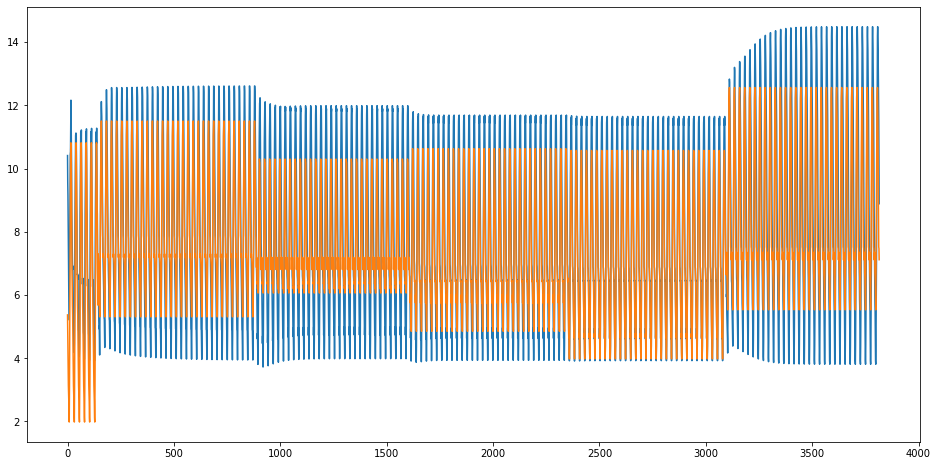

In [46]:
fig = plt.figure(figsize=(16,8))
plt.plot(lista)
#plt.show()
plt.plot(test.prom.values)
#lista = test.prom.values.flatten()

En azul las predicciones.

En naranjo las medias (mes,hora) obtenidas usando los datos (2013,2014).

Se puede apreciar que las predicciones son extremandamente uniformes. Esto es esperable, ya que el input consiste en la media mensual y la media de la hora. El valor del target (por sí solo) converge a un número debido al efecto conocido como "cono de incertidumbre" en el contexto de una predicción multi-step recursiva. Los valores (mean_mes,mean_hora) consiguen perturbar esta constante de manera oportuna.

Sin embargo, este enfoque parece ser una aproximación de las medias (mean_mes,mean_hora) de los años anteriores (en naranjo).

Tras una conversación con las personas que plantearon el Challenge, el problema en particular parece tener como mejor solución utilizar las medias (mean_mes,mean_hora). Esto es debido a que el horizonte de tiempo es excesivamente grande: 5 meses. Un horizonte de tiempo de 3 días ya se considera el límite para aproximar la velocidad del viento de manera competitiva en el estado del arte.

Este enfoque se planteó conociendo de antemano esta problemática. Aún así se intentó generar un modelo que pudiera ser competitivo con el uso de las medias. 

## Prediccion

Se tiene un valor predicho para cada hora por los próximos 5 meses. 

Sin embargo, los valores a predecir están en una escala de [10 min].

Para las predicciones finales se propone lo siguiente:

    - Ubicar al dato entre las 2 horas correspondientes.
    - Extraer la predicción de ambas horas.
    - Ponderar estas 2 predicciones de acuerdo a la cercanía del dato con cada hora.
    
**Update después de la competencia**

Este enfoque resultó superior al enfoque más simple de asignar la predicción de la hora que acompaña al dato.

In [47]:
serie = pd.Series(lista,index=test.index,name='predicciones')
forecast = pd.read_csv(path+'windspeed-testing.csv',header=None)
forecast.columns = ['Fecha']
forecast['Fecha'] =  pd.to_datetime(forecast['Fecha'],format="%d-%m-%Y %H:%M")
forecast['year'] = forecast.Fecha.dt.year
forecast['hour'] = forecast.Fecha.dt.hour
forecast['minute'] = forecast.Fecha.dt.minute/120 

forecast['day'] = forecast.Fecha.dt.day
forecast['month'] = forecast.Fecha.dt.month
#forecast

In [48]:
forecast['hour2'] = forecast.hour+1
forecast.loc[forecast['hour2'] == 24,'hour2'] = 23
forecast = forecast.join(serie,on=['month','day','hour'])
forecast = forecast.join(serie,on=['month','day','hour2'],rsuffix='_')
forecast['final'] = forecast['predicciones'] * (1-forecast['minute']) + forecast['predicciones_'] * forecast['minute']
forecast 

,Fecha,year,hour,minute,day,month,hour2,predicciones,predicciones_,final
0,2015-04-26 01:50:00,2015,1,0.416667,26,4,2,6.919224,6.095706,6.576092
1,2015-04-26 03:10:00,2015,3,0.083333,26,4,4,5.148370,5.139524,5.147633
2,2015-04-26 04:20:00,2015,4,0.166667,26,4,5,5.139524,4.999687,5.116218
3,2015-04-26 05:20:00,2015,5,0.166667,26,4,6,4.999687,4.495651,4.915681
4,2015-04-26 06:40:00,2015,6,0.333333,26,4,7,4.495651,4.179814,4.390372
...,...,...,...,...,...,...,...,...,...,...
1995,2015-09-19 08:10:00,2015,8,0.083333,19,9,9,4.434992,5.511635,4.524713
1996,2015-09-21 11:20:00,2015,11,0.166667,21,9,12,7.814844,9.484267,8.093081
1997,2015-09-22 10:30:00,2015,10,0.250000,22,9,11,6.208894,7.814378,6.610265
1998,2015-09-23 17:30:00,2015,17,0.250000,23,9,18,14.115721,13.738928,14.021523


In [49]:
predicciones = forecast['final'].values
predicciones.shape

(2000,)

In [50]:
submission = pd.read_csv(path+'sampleSubmission.csv')
submission[submission.columns[1]] = predicciones
submission.to_csv('final.csv',index=False)
submission

,'Fecha','Velocidad de viento en 20.0 metros [mean]'
0,26-04-2015 01:50,6.576092
1,26-04-2015 03:10,5.147633
2,26-04-2015 04:20,5.116218
3,26-04-2015 05:20,4.915681
4,26-04-2015 06:40,4.390372
...,...,...
1995,19-09-2015 08:10,4.524713
1996,21-09-2015 11:20,8.093081
1997,22-09-2015 10:30,6.610265
1998,23-09-2015 17:30,14.021523
